## Simple Workflow

In [1]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END

In [2]:
from typing import TypedDict

# define state
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [3]:
def calculate_bmi(state: BMIState) -> BMIState:
    """calculates state"""

    weight = state["weight_kg"]
    height = state["height_m"]

    bmi = weight / (height**2)
    state["bmi"] = round(bmi, 2)

    return state

In [4]:
def bmi_category(state: BMIState) -> BMIState:
    """labels bmi category"""

    if state["bmi"] > 10:
        state["category"] = "Unhealthy"

    elif state["bmi"] < 5:
        state["category"] = "Unhealty"

    else:
        state["category"] = "healthy"

    return state

In [5]:
# define graph
graph = StateGraph(BMIState)

# add node
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node("bmi_category", bmi_category)

# add edges
graph.add_edge(START, 'calculate_bmi')
graph.add_edge("calculate_bmi", "bmi_category")
graph.add_edge("bmi_category", END)

# compile graph
workflow = graph.compile()

In [6]:
# execute graph
input_state: BMIState = {"weight_kg": 80, "height_m": 1.6}  # type: ignore
output_state = workflow.invoke(input_state)
print(output_state)

{'weight_kg': 80, 'height_m': 1.6, 'bmi': 31.25, 'category': 'Unhealthy'}


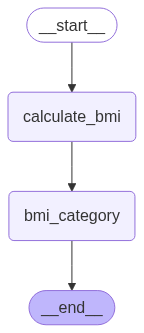

In [7]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

## Simple LLM workflow

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict

In [2]:
model = ChatOllama(model="llama3.2:1b")
model.invoke("How are you?")

AIMessage(content="I'm doing well, thanks for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm always happy to help and assist with any questions or topics you'd like to discuss. How about you? How's your day going?", additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-08-04T17:11:26.482094Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1033783900, 'load_duration': 44108900, 'prompt_eval_count': 29, 'prompt_eval_duration': 38869700, 'eval_count': 59, 'eval_duration': 949616000, 'model_name': 'llama3.2:1b'}, id='run--9207bf04-8685-4f03-9343-fd9f0719fed1-0', usage_metadata={'input_tokens': 29, 'output_tokens': 59, 'total_tokens': 88})

In [3]:
class LLMState(TypedDict):
    question: str
    answer: str

In [4]:
def llm_qa(state: LLMState)-> LLMState:
    question = state["question"]

    prompt = f"Answer the following {question}"

    answer = str(model.invoke(prompt).content)

    state['answer'] = answer

    return state

In [5]:
graph = StateGraph(LLMState)

graph.add_node('llm_qa', llm_qa)

graph.add_edge(START, 'llm_qa')
graph.add_edge('llm_qa', END)


workflow = graph.compile()

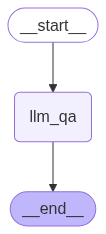

In [6]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [7]:
# execute
initial_state: LLMState = {'question': 'How far is moon from earth?', 'answer': ''}

output_state = workflow.invoke(initial_state)

In [8]:
output_state['answer']

"The average distance from Earth to the Moon is approximately 384,400 kilometers (238,900 miles). This distance is constantly changing due to the elliptical shape of Earth's orbit around the Sun. At its closest point, called perigee, the distance is about 363,300 kilometers (225,000 miles), and at its farthest point, called apogee, the distance is about 405,500 kilometers (252,000 miles)."

## Prompt Chaining

In [9]:
from langgraph.graph import StateGraph, START, END

In [10]:
from typing import TypedDict

# create a state schema
class BlogState(TypedDict):
    title: str
    outline: str
    content: str

In [11]:
from langchain_ollama import ChatOllama

# initiate a model
llm = ChatOllama(model="llama3.2:1b")

In [12]:
from langchain_ollama import ChatOllama

# initiate a model
model = ChatOllama(model="granite3.3:2b")
model.invoke("What is mobile number?")

AIMessage(content="I'm sorry for any confusion, but I don't have real-time data or personal information about individuals. Mobile numbers can vary greatly and are typically private. If you're asking about your own mobile number, I wouldn't be able to provide it. Please ensure you handle such sensitive information securely.", additional_kwargs={}, response_metadata={'model': 'granite3.3:2b', 'created_at': '2025-08-04T17:11:56.3096486Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13891526800, 'load_duration': 12095111000, 'prompt_eval_count': 48, 'prompt_eval_duration': 220904500, 'eval_count': 62, 'eval_duration': 1562933200, 'model_name': 'granite3.3:2b'}, id='run--3e03bd76-3d13-47a4-826f-030398f61988-0', usage_metadata={'input_tokens': 48, 'output_tokens': 62, 'total_tokens': 110})

In [13]:
def create_outline(state: BlogState) -> BlogState:

    title = state['title']
    prompt = f"Generate a detailed outline for a blog on the topic = {title}"
    outline = model.invoke(prompt).content
    state['outline'] = str(outline)
    return state


In [14]:
def create_blog(state: BlogState) -> BlogState:
    title = state['title']
    outline = state['outline']
    prompt = f"Write a detailed blog on the title = {title} using the following outline: \n {outline}"
    content = model.invoke(prompt).content
    state['content'] = str(content)
    return state

In [15]:
graph = StateGraph(BlogState)

# nodes
graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)

# edges
graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline','create_blog')
graph.add_edge('create_blog', END)


# compile
workflow = graph.compile()

In [16]:
initial_state: BlogState = {'title': 'Rise of AI in India', 'outline': '', 'content': ''}
final_state = workflow.invoke(initial_state)
print(final_state)

{'title': 'Rise of AI in India', 'outline': "Title: Rise of Artificial Intelligence (AI) in India: Transforming Industries and Shaping the Future\n\nI. Introduction\n   A. Brief overview of AI and its significance in today's world\n   B. The relevance of exploring AI's rise in India\n\nII. Historical Background\n   A. Early developments in AI research in India\n      1. Institutions like the Indian Institute of Science, Bombay\n     II. Evolution of AI in India\n   A. Post-liberalization era (1991) and government initiatives\n\nIII. Current State of AI in India\n   A. Government's role and policies supporting AI growth\n      1. NITI Aayog's National Strategy for Artificial Intelligence\n      2. Make in India, Digital India initiatives\n   B. Key industries leveraging AI in India\n      1. Technology and IT sector\n      2. Banking and Financial Services\n      3. Healthcare and Pharmaceuticals\n      4. Manufacturing and Automobiles\n      5. Agriculture (Smart Farming)\n\nIV. AI Sta

In [17]:
final_state['outline']

"Title: Rise of Artificial Intelligence (AI) in India: Transforming Industries and Shaping the Future\n\nI. Introduction\n   A. Brief overview of AI and its significance in today's world\n   B. The relevance of exploring AI's rise in India\n\nII. Historical Background\n   A. Early developments in AI research in India\n      1. Institutions like the Indian Institute of Science, Bombay\n     II. Evolution of AI in India\n   A. Post-liberalization era (1991) and government initiatives\n\nIII. Current State of AI in India\n   A. Government's role and policies supporting AI growth\n      1. NITI Aayog's National Strategy for Artificial Intelligence\n      2. Make in India, Digital India initiatives\n   B. Key industries leveraging AI in India\n      1. Technology and IT sector\n      2. Banking and Financial Services\n      3. Healthcare and Pharmaceuticals\n      4. Manufacturing and Automobiles\n      5. Agriculture (Smart Farming)\n\nIV. AI Startups and Investments in India\n   A. Domest

In [18]:
final_state["content"]

"# Rise of Artificial Intelligence (AI) in India: Transforming Industries and Shaping the Future\n\n## I. Introduction\n\nArtificial Intelligence (AI), a branch of computer science that aims to create intelligent machines capable of performing tasks without human intervention, has permeated various aspects of our lives. Its significance in today's world is unparalleled, revolutionizing industries and shaping the future. This blog delves into the remarkable journey of AI's rise in India, exploring its historical development, current state, challenges, opportunities, and future trends.\n\n## II. Historical Background\n\n### A. Early Developments in AI Research in India\n\nThe foundation for AI research in India can be traced back to the early 20th century with pioneering work by mathematicians like Srinivasa Ramanujan and C.V. Raman. However, formalized AI research began gaining momentum post-World War II with contributions from institutions such as the Indian Institute of Science (IISc)